### Test env for EMA-SMA Crossover algo using MC and option pricing priciple for optimal portfolio weighting

In [1]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import alpaca_trade_api as tradeapi
import os
from dotenv import load_dotenv
from alpaca_trade_api.rest import TimeFrame
import datetime as dt_
import pytz
from time import sleep
from scipy import stats
from matplotlib import pyplot as plt
import statsmodels.api as sm

In [2]:
load_dotenv()
API_KEY = os.getenv("ALPACA_API_KEY")
SECRET_KEY = os.getenv("ALPACA_SECRET_KEY")
END_POINT = os.getenv("ALPACA_END_POINT")

In [3]:
api = tradeapi.REST(API_KEY, SECRET_KEY, END_POINT)

In [81]:
def get_stocks(tickers: list[str], timeframe: str, start: str, end: str) -> pd.DataFrame:
    """
    timeframe: 1min | 5min | 15min | 1hour | 1day | 1week
    """
    stock_dfs = []
    
    for ticker in tickers:
        bars = api.get_bars(ticker, timeframe, start, end).df
        bars.reset_index(inplace=True)
        stock_df = pd.DataFrame({
            'timestamp': bars['timestamp'],
            ticker: bars['close']
        })
        stock_dfs.append(stock_df)

    merged_df = stock_dfs[0]
    
    for stock_df in stock_dfs[1:]:
        merged_df = pd.merge(merged_df, stock_df, on='timestamp', how='inner')

    merged_df.reset_index(drop=True, inplace=True)
    
    return merged_df

In [82]:
tickers = ['AAPL','XOM']

stocks = get_stocks(tickers, '3hour', '2024-09-01', '2024-12-01')
stocks

,timestamp,AAPL,XOM
0,2024-09-03 06:00:00+00:00,228.5900,118.0700
1,2024-09-03 09:00:00+00:00,227.8400,116.8800
2,2024-09-03 12:00:00+00:00,223.6450,114.7500
3,2024-09-03 15:00:00+00:00,223.2100,115.7900
4,2024-09-03 18:00:00+00:00,222.0000,115.4913
...,...,...,...
362,2024-11-29 09:00:00+00:00,234.4200,118.0600
363,2024-11-29 12:00:00+00:00,235.6400,117.9800
364,2024-11-29 15:00:00+00:00,237.3400,118.0600
365,2024-11-29 18:00:00+00:00,237.5000,117.9700


In [83]:
def generate_brownian_motion_params(S_t, ticker:str)->pd.DataFrame:
    time = np.array([i+1 for i in range(len(S_t)-1)])
    S = S_t[1:]
    S_lag = S_t[:-1]
    X = pd.DataFrame({'Time': time, 'S_lag': S_lag})
    X = sm.add_constant(X)
    S_m = sm.OLS(S, X).fit()
    ser = np.sqrt(S_m.mse_resid)
    bm = {
    f'{ticker}:ser': ser,
    f'{ticker}:Time': S_m.params['Time'],
    f'{ticker}:S_lag': S_m.params['S_lag'],
    f'{ticker}:Drift': S_m.params['const'],
    f'{ticker}:Drift_SE': S_m.bse['const'],
    }
    drift_t = [S[i] - time[i]*bm[f'{ticker}:Time'] - S_lag[i]*bm[f'{ticker}:S_lag'] - np.array(S_m.resid)[i] for i in range(len(S))]
    drift_resid = pd.DataFrame({"Drift": drift_t, "Resid": S_m.resid})
    bm[f'{ticker}:Drift_Resid_Corr'] = drift_resid.corr()
    return pd.DataFrame([bm])

In [ ]:
df = stocks.copy()

for ticker in tickers:
    # Calculate EMA and SMA
    df[f'{ticker}:ema_12'] = ta.ema(df[ticker], length=12)
    df[f'{ticker}:sma_12'] = ta.sma(df[ticker], length=12)

    df[f'{ticker}:signal'] = 0
    df[f'{ticker}:signal'][df[f'{ticker}:ema_12'] < df[f'{ticker}:sma_12']] = 1  # Buy
    df[f'{ticker}:signal'][df[f'{ticker}:ema_12'] > df[f'{ticker}:sma_12']] = -1  # Sell

    # df[f'{ticker}:rsi'] = ta.rsi(df[ticker], length=12)

    # df[f'{ticker}:signal'] = 0
    # df[f'{ticker}:signal'][df[f'{ticker}:rsi'] > 70] = 1  # Buy
    # df[f'{ticker}:signal'][df[f'{ticker}:rsi'] < 30] = -1  # Sell



    df[f'{ticker}:position'] = 0  

for ticker in tickers:
    positions = [0]  

    for i in range(1, len(df)):
        if df[f'{ticker}:signal'].iloc[i]== 1 and positions[-1] == 0:
            positions.append(1)  # Buy
        elif df[f'{ticker}:signal'].iloc[i]==-1 and positions[-1] == 1:
            positions.append(0)  # Sell
        else:
            positions.append(positions[-1]) # Hold

    df[f'{ticker}:position'] = positions

df

C:\Users\naths\AppData\Local\Temp\ipykernel_21648\769662426.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[f'{ticker}:signal'][df[f'{ticker}:ema_12'] < df[f'{ticker}:sma_12']] = 1  # Buy
C:\Users\naths\AppData\Local\Temp\ipykernel_21

,timestamp,AAPL,XOM,AAPL:ema_12,AAPL:sma_12,AAPL:signal,AAPL:position,XOM:ema_12,XOM:sma_12,XOM:signal,XOM:position
0,2024-09-03 06:00:00+00:00,228.5900,118.0700,NaN,NaN,0,0,NaN,NaN,0,0
1,2024-09-03 09:00:00+00:00,227.8400,116.8800,NaN,NaN,0,0,NaN,NaN,0,0
2,2024-09-03 12:00:00+00:00,223.6450,114.7500,NaN,NaN,0,0,NaN,NaN,0,0
3,2024-09-03 15:00:00+00:00,223.2100,115.7900,NaN,NaN,0,0,NaN,NaN,0,0
4,2024-09-03 18:00:00+00:00,222.0000,115.4913,NaN,NaN,0,0,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...
362,2024-11-29 09:00:00+00:00,234.4200,118.0600,234.339069,234.906808,1,1,118.365206,118.055208,-1,0
363,2024-11-29 12:00:00+00:00,235.6400,117.9800,234.539212,234.975975,1,1,118.305944,118.027892,-1,0
364,2024-11-29 15:00:00+00:00,237.3400,118.0600,234.970103,235.170975,1,1,118.268106,118.006225,-1,0
365,2024-11-29 18:00:00+00:00,237.5000,117.9700,235.359318,235.372642,1,1,118.222244,118.005392,-1,0


In [97]:

for ticker in tickers:
    df[f'{ticker}:ser'] = 0
    df[f'{ticker}:Time'] = 0
    df[f'{ticker}:S_lag'] = 0
    df[f'{ticker}:Drift'] = 0
    df[f'{ticker}:Drift_SE'] = 0
    df[f'{ticker}:Drift_Resid_Corr'] = None
    print(f'Starting:{ticker}')
    for i in range(24, len(df)):
        S_t = np.array(df[ticker].to_list()[i-24:i+1])
        AR_params = generate_brownian_motion_params(S_t, ticker).iloc[0]
        df.loc[i, AR_params.index] = AR_params

df.dropna(inplace=True)

df


Starting:AAPL


C:\Users\naths\AppData\Local\Temp\ipykernel_21648\758846655.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.2058757685250012' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i, AR_params.index] = AR_params
C:\Users\naths\AppData\Local\Temp\ipykernel_21648\758846655.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.010152133936432106' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i, AR_params.index] = AR_params
C:\Users\naths\AppData\Local\Temp\ipykernel_21648\758846655.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.631625301161892' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc

Starting:XOM


C:\Users\naths\AppData\Local\Temp\ipykernel_21648\758846655.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.49224342495376355' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i, AR_params.index] = AR_params
C:\Users\naths\AppData\Local\Temp\ipykernel_21648\758846655.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.11036131171739072' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i, AR_params.index] = AR_params
C:\Users\naths\AppData\Local\Temp\ipykernel_21648\758846655.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.27315723611997456' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.

,timestamp,AAPL,XOM,AAPL:ema_12,AAPL:sma_12,AAPL:signal,AAPL:position,XOM:ema_12,XOM:sma_12,XOM:signal,...,AAPL:S_lag,AAPL:Drift,AAPL:Drift_SE,AAPL:Drift_Resid_Corr,XOM:ser,XOM:Time,XOM:S_lag,XOM:Drift,XOM:Drift_SE,XOM:Drift_Resid_Corr
24,2024-09-09 09:00:00+00:00,221.2000,113.2500,221.490882,221.630700,1,1,113.227986,113.146875,-1,...,0.631625,81.332551,27.223500,Drift Resid Drift 1.000000 0.0...,0.492243,-0.110361,0.273157,84.278731,21.425652,Drift Resid Drift 1.000000 -0.1...
25,2024-09-09 12:00:00+00:00,217.2000,114.8400,220.830746,221.360700,1,1,113.475988,113.182708,-1,...,0.424067,127.531222,35.825544,Drift Resid Drift 1.000000 0.0...,0.656629,-0.038025,0.539844,52.907611,32.162721,Drift Resid Drift 1.000000 0.1...
26,2024-09-09 15:00:00+00:00,219.1694,116.0217,220.575154,220.983150,1,1,113.867636,113.314517,-1,...,0.469630,117.464633,41.798587,Drift Resid Drift 1.000000 0.0...,0.608345,0.042268,1.117602,-13.887243,21.510423,Drift Resid Drift NaN NaN Resid ...
27,2024-09-09 18:00:00+00:00,221.0449,115.0400,220.647423,220.769392,1,1,114.048000,113.420350,-1,...,0.407089,131.064576,42.740230,Drift Resid Drift 1.000000 -0.0...,0.601280,0.017556,0.895846,11.633027,15.088435,Drift Resid Drift 1.000000 0.2...
28,2024-09-09 21:00:00+00:00,220.8797,115.3890,220.683158,220.645200,-1,0,114.254308,113.594433,-1,...,0.404286,131.659949,43.861907,Drift Resid Drift 1.000000 0.1...,0.602537,0.022416,0.910922,9.876262,13.981427,Drift Resid Drift 1.000000 0.0...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,2024-11-29 09:00:00+00:00,234.4200,118.0600,234.339069,234.906808,1,1,118.365206,118.055208,-1,...,0.403037,137.130400,49.434560,Drift Resid Drift 1.000000 -0.1...,0.638338,-0.119109,0.467581,65.098053,25.343128,Drift Resid Drift 1.000000 0.0...
363,2024-11-29 12:00:00+00:00,235.6400,117.9800,234.539212,234.975975,1,1,118.305944,118.027892,-1,...,0.383757,141.806192,45.971587,Drift Resid Drift 1.000000 -0.0...,0.645872,-0.105555,0.516385,59.015442,24.246961,Drift Resid Drift 1.00000 -0.1132...
364,2024-11-29 15:00:00+00:00,237.3400,118.0600,234.970103,235.170975,1,1,118.268106,118.006225,-1,...,0.364275,146.314879,47.283159,Drift Resid Drift 1.000000 0.2...,0.578596,-0.052987,0.656490,41.494999,20.772941,Drift Resid Drift 1.000000 0.0...
365,2024-11-29 18:00:00+00:00,237.5000,117.9700,235.359318,235.372642,1,1,118.222244,118.005392,-1,...,0.371909,144.691232,46.868707,Drift Resid Drift 1.000000 0.1...,0.580954,-0.044026,0.690207,37.323939,20.396886,Drift Resid Drift 1.000000 -0.0...


In [43]:
# df.to_csv('Dual_stock_data_prep.csv')

#### Simulate trading by optimizing portfolio weights by using N=100 MC sims

In [98]:
dt = df.copy()
dt.reset_index(inplace=True)
stock_prices = df[tickers]
stock_corr = stock_prices.corr()
stock_corr

,AAPL,XOM
AAPL,1.000000,0.360566
XOM,0.360566,1.000000


In [99]:
N = 100
M = len(dt)
T = 12
t = [i+1 for i in range(T)]
dt['weights'] = 0

for i in range(M):
    filled_length = int(50 * i / M)
    progress = "=" * filled_length + " " * (50 - filled_length)
    print(f"\rProgress: [{progress}] {i}/{M}", end="")

    data = dt.loc[i]
    price_patterns = {}
    ticker_count = {ticker: 0 for ticker in tickers}
    u_t_matrix = np.random.normal(size=(N,T, len(tickers)))
    L_u = np.linalg.cholesky(stock_corr)
    for j in range(N):
        for k in range(T):
            u_t_matrix[j][k] = np.inner(L_u, u_t_matrix[j][k])

    for (q, ticker) in enumerate(tickers):
        if data[ticker + ':signal'] == 1:
            price_patterns[ticker] = np.zeros(N)
            # print(ticker)
            for j in range(N):
                S_t = [0 for _ in range(T)]
                S_t[0] = data[ticker]
                for k in range(1, T):
                    drift = np.random.normal(dt.loc[i, f'{ticker}:Drift'], 0.5*dt.loc[i, f'{ticker}:Drift_SE'])
                    u = dt.loc[i, f'{ticker}:ser']*u_t_matrix[j][k][q]
                    L = np.linalg.cholesky(dt.loc[i, f'{ticker}:Drift_Resid_Corr'])
                    dift, u_t = np.dot(L, np.array([drift, u]))
                    S_t[k] = drift + (k+i)*dt.loc[i, f'{ticker}:Time'] + S_t[k-1]*dt.loc[i, f'{ticker}:S_lag'] + u_t
                price_patterns[ticker][j] = 100*(S_t[-1] / S_t[0] - 1 )

    price_patterns = pd.DataFrame(price_patterns)
    
    price_patterns['Best_Ticker'] = price_patterns.idxmax(axis=1, skipna=True)
    counts = price_patterns['Best_Ticker'].value_counts()
    weights = {}
    for ticker in tickers:
        if ticker in counts:
            weights[ticker+':w'] = counts[ticker] / N
    weights_df = pd.DataFrame([weights]).iloc[0]
    dt.loc[i, weights_df.index] = weights_df
    

Progress: [====                                              ] 32/343

C:\Users\naths\AppData\Local\Temp\ipykernel_21648\951967714.py:38: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  price_patterns['Best_Ticker'] = price_patterns.idxmax(axis=1, skipna=True)


Progress: [========                                          ] 61/343

C:\Users\naths\AppData\Local\Temp\ipykernel_21648\951967714.py:38: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  price_patterns['Best_Ticker'] = price_patterns.idxmax(axis=1, skipna=True)


Progress: [===========                                       ] 78/343

C:\Users\naths\AppData\Local\Temp\ipykernel_21648\951967714.py:38: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  price_patterns['Best_Ticker'] = price_patterns.idxmax(axis=1, skipna=True)


Progress: [==============                                    ] 100/343

C:\Users\naths\AppData\Local\Temp\ipykernel_21648\951967714.py:38: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  price_patterns['Best_Ticker'] = price_patterns.idxmax(axis=1, skipna=True)


Progress: [==================                                ] 130/343

C:\Users\naths\AppData\Local\Temp\ipykernel_21648\951967714.py:38: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  price_patterns['Best_Ticker'] = price_patterns.idxmax(axis=1, skipna=True)


Progress: [===================                               ] 132/343

C:\Users\naths\AppData\Local\Temp\ipykernel_21648\951967714.py:38: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  price_patterns['Best_Ticker'] = price_patterns.idxmax(axis=1, skipna=True)


Progress: [======================                            ] 151/343

C:\Users\naths\AppData\Local\Temp\ipykernel_21648\951967714.py:38: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  price_patterns['Best_Ticker'] = price_patterns.idxmax(axis=1, skipna=True)
C:\Users\naths\AppData\Local\Temp\ipykernel_21648\951967714.py:38: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  price_patterns['Best_Ticker'] = price_patterns.idxmax(axis=1, skipna=True)


Progress: [=======================                           ] 162/343

C:\Users\naths\AppData\Local\Temp\ipykernel_21648\951967714.py:38: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  price_patterns['Best_Ticker'] = price_patterns.idxmax(axis=1, skipna=True)


Progress: [========================                          ] 168/343

C:\Users\naths\AppData\Local\Temp\ipykernel_21648\951967714.py:38: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  price_patterns['Best_Ticker'] = price_patterns.idxmax(axis=1, skipna=True)


Progress: [=========================                         ] 174/343

C:\Users\naths\AppData\Local\Temp\ipykernel_21648\951967714.py:38: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  price_patterns['Best_Ticker'] = price_patterns.idxmax(axis=1, skipna=True)


Progress: [==============================                    ] 212/343

C:\Users\naths\AppData\Local\Temp\ipykernel_21648\951967714.py:38: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  price_patterns['Best_Ticker'] = price_patterns.idxmax(axis=1, skipna=True)


Progress: [================================                  ] 223/343

C:\Users\naths\AppData\Local\Temp\ipykernel_21648\951967714.py:38: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  price_patterns['Best_Ticker'] = price_patterns.idxmax(axis=1, skipna=True)
C:\Users\naths\AppData\Local\Temp\ipykernel_21648\951967714.py:38: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  price_patterns['Best_Ticker'] = price_patterns.idxmax(axis=1, skipna=True)


Progress: [=======================================           ] 271/343

C:\Users\naths\AppData\Local\Temp\ipykernel_21648\951967714.py:38: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  price_patterns['Best_Ticker'] = price_patterns.idxmax(axis=1, skipna=True)


Progress: [===============================================   ] 325/343

C:\Users\naths\AppData\Local\Temp\ipykernel_21648\951967714.py:38: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  price_patterns['Best_Ticker'] = price_patterns.idxmax(axis=1, skipna=True)


Progress: [================================================  ] 331/343

C:\Users\naths\AppData\Local\Temp\ipykernel_21648\951967714.py:38: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  price_patterns['Best_Ticker'] = price_patterns.idxmax(axis=1, skipna=True)


Progress: [================================================= ] 342/343

In [48]:
# dt.to_csv('Dual_stock_data_weights.csv')

In [73]:
# dt = pd.read_csv('Dual_stock_data_weights.csv')

# dt.reset_index(inplace=True)
# dt = dt.fillna(0)

In [100]:
dt = dt.fillna(0)


In [101]:
dt

,index,timestamp,AAPL,XOM,AAPL:ema_12,AAPL:sma_12,AAPL:signal,AAPL:position,XOM:ema_12,XOM:sma_12,...,AAPL:Drift_Resid_Corr,XOM:ser,XOM:Time,XOM:S_lag,XOM:Drift,XOM:Drift_SE,XOM:Drift_Resid_Corr,weights,AAPL:w,XOM:w
0,24,2024-09-09 09:00:00+00:00,221.2000,113.2500,221.490882,221.630700,1,1,113.227986,113.146875,...,Drift Resid Drift 1.000000 0.0...,0.492243,-0.110361,0.273157,84.278731,21.425652,Drift Resid Drift 1.000000 -0.1...,0,1.0,0.0
1,25,2024-09-09 12:00:00+00:00,217.2000,114.8400,220.830746,221.360700,1,1,113.475988,113.182708,...,Drift Resid Drift 1.000000 0.0...,0.656629,-0.038025,0.539844,52.907611,32.162721,Drift Resid Drift 1.000000 0.1...,0,1.0,0.0
2,26,2024-09-09 15:00:00+00:00,219.1694,116.0217,220.575154,220.983150,1,1,113.867636,113.314517,...,Drift Resid Drift 1.000000 0.0...,0.608345,0.042268,1.117602,-13.887243,21.510423,Drift Resid Drift NaN NaN Resid ...,0,1.0,0.0
3,27,2024-09-09 18:00:00+00:00,221.0449,115.0400,220.647423,220.769392,1,1,114.048000,113.420350,...,Drift Resid Drift 1.000000 -0.0...,0.601280,0.017556,0.895846,11.633027,15.088435,Drift Resid Drift 1.000000 0.2...,0,1.0,0.0
4,28,2024-09-09 21:00:00+00:00,220.8797,115.3890,220.683158,220.645200,-1,0,114.254308,113.594433,...,Drift Resid Drift 1.000000 0.1...,0.602537,0.022416,0.910922,9.876262,13.981427,Drift Resid Drift 1.000000 0.0...,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,362,2024-11-29 09:00:00+00:00,234.4200,118.0600,234.339069,234.906808,1,1,118.365206,118.055208,...,Drift Resid Drift 1.000000 -0.1...,0.638338,-0.119109,0.467581,65.098053,25.343128,Drift Resid Drift 1.000000 0.0...,0,1.0,0.0
339,363,2024-11-29 12:00:00+00:00,235.6400,117.9800,234.539212,234.975975,1,1,118.305944,118.027892,...,Drift Resid Drift 1.000000 -0.0...,0.645872,-0.105555,0.516385,59.015442,24.246961,Drift Resid Drift 1.00000 -0.1132...,0,1.0,0.0
340,364,2024-11-29 15:00:00+00:00,237.3400,118.0600,234.970103,235.170975,1,1,118.268106,118.006225,...,Drift Resid Drift 1.000000 0.2...,0.578596,-0.052987,0.656490,41.494999,20.772941,Drift Resid Drift 1.000000 0.0...,0,1.0,0.0
341,365,2024-11-29 18:00:00+00:00,237.5000,117.9700,235.359318,235.372642,1,1,118.222244,118.005392,...,Drift Resid Drift 1.000000 0.1...,0.580954,-0.044026,0.690207,37.323939,20.396886,Drift Resid Drift 1.000000 -0.0...,0,1.0,0.0


In [103]:
M = len(dt)
cash = 10000  # Initial cash (10,000 USD)
portfolio_value = cash
positions = {ticker: 0 for ticker in tickers}  # Initialize positions to 0 for all tickers
portfolio_performance = [cash]  # Track portfolio value over time
curr_pos = {ticker: 0 for ticker in tickers}  # Track the last recorded positions
change_portfolio = False  # Flag to indicate if a trade is needed
spread = 0  # 0.5% spread cost
weight_diff_threshold = 0.5  # 50% weight difference threshold
c = 0  # Counter for trades

for i in range(M):
    # Display progress
    filled_length = int(50 * i / M)
    progress = "=" * filled_length + " " * (50 - filled_length)
    print(f"\rProgress: [{progress}] {i}/{M}", end="")
    
    data = dt.loc[i]
    
    # Calculate current portfolio value
    pf = cash
    for ticker in tickers:
        pf += data[ticker] * positions[ticker]
    portfolio_performance.append(pf)
    
    # Check for changes in position signals or significant weight differences
    for ticker in tickers:
        new_weight = data[f'{ticker}:w']
        current_weight = (positions[ticker] * data[ticker]) / pf if pf > 0 else 0
        weight_diff = abs(new_weight - current_weight) / max(current_weight, 1e-6)  # Avoid division by zero
        
        if curr_pos[ticker] != data[f'{ticker}:position']:# weight_diff > weight_diff_threshold:
            change_portfolio = True
            break  # Exit loop early if any change is detected
    
    # Update portfolio if there's a change
    if change_portfolio:
        # Sell all current positions
        for ticker in tickers:
            if positions[ticker] > 0:  # If we hold the stock
                sell_price = data[ticker] * (1 - spread)  # Adjust for spread
                cash += positions[ticker] * sell_price  # Cash received after spread
                positions[ticker] = 0
        
        # Buy new positions based on weights
        for ticker in tickers:
            if data[f'{ticker}:position'] == 1:  # Buy signal
                buy_price = data[ticker] * (1 + spread)  # Adjust for spread
                buy_cash = cash * data[f'{ticker}:w']  # Allocate cash based on weight
                qty = buy_cash // buy_price  # Calculate quantity to buy
                positions[ticker] = qty
                cash -= qty * buy_price  # Deduct spent cash after spread
        
        # Update current position tracking
        for ticker in tickers:
            curr_pos[ticker] = data[f'{ticker}:position']
        
        c += 1  # Increment trade counter
        change_portfolio = False  # Reset flag

c


Progress: [================================================= ] 342/343

69

In [52]:
# M = len(dt)
# cash = 10000 # 10,000 USD
# portfolio_value = cash
# possitions = {}
# for ticker in tickers:
#     possitions[ticker] = 0

# portfolio_performance = [cash]

# for i in range(M):
#     filled_length = int(50 * i / M)
#     progress = "=" * filled_length + " " * (50 - filled_length)
#     print(f"\rProgress: [{progress}] {i}/{M}", end="")
#     data = dt.loc[i]
#     pf = cash
#     for ticker in tickers:
#         pf += data[ticker]*possitions[ticker]

#     cash = pf
#     portfolio_performance.append(pf)

#     for ticker in tickers:
#         buy_cash = cash*data[f'{ticker}:w']
#         qty = buy_cash // (data[ticker])
#         possitions[ticker] = qty
#         cash -= data[ticker]*qty

Progress: [================================================  ] 38/39

In [104]:
result_df = dt[tickers]
for ticker in tickers:
    result_df[f'{ticker}:norm'] = (result_df[ticker] / result_df.loc[0, ticker] - 1)*100

result_df['Portfolio'] = np.array(portfolio_performance)[1:]
result_df['Portfolio:norm'] = (result_df['Portfolio'] / result_df.loc[0, 'Portfolio'] - 1)*100
result_df['date'] = dt['timestamp']
result_df['date'] = pd.to_datetime(result_df['date'])

result_df

C:\Users\naths\AppData\Local\Temp\ipykernel_21648\184900262.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df[f'{ticker}:norm'] = (result_df[ticker] / result_df.loc[0, ticker] - 1)*100
C:\Users\naths\AppData\Local\Temp\ipykernel_21648\184900262.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df[f'{ticker}:norm'] = (result_df[ticker] / result_df.loc[0, ticker] - 1)*100
C:\Users\naths\AppData\Local\Temp\ipykernel_21648\184900262.py:5: SettingWithCopyWarning: 
A value is trying to be set

,AAPL,XOM,AAPL:norm,XOM:norm,Portfolio,Portfolio:norm,date
0,221.2000,113.2500,0.000000,0.000000,10000.0000,0.000000,2024-09-09 09:00:00+00:00
1,217.2000,114.8400,-1.808318,1.403974,9820.0000,-1.800000,2024-09-09 12:00:00+00:00
2,219.1694,116.0217,-0.917993,2.447417,9908.6230,-0.913770,2024-09-09 15:00:00+00:00
3,221.0449,115.0400,-0.070118,1.580574,9993.0205,-0.069795,2024-09-09 18:00:00+00:00
4,220.8797,115.3890,-0.144801,1.888742,9985.5865,-0.144135,2024-09-09 21:00:00+00:00
...,...,...,...,...,...,...,...
338,234.4200,118.0600,5.976492,4.247241,9833.4563,-1.665437,2024-11-29 09:00:00+00:00
339,235.6400,117.9800,6.528029,4.176600,9883.4763,-1.165237,2024-11-29 12:00:00+00:00
340,237.3400,118.0600,7.296564,4.247241,9953.1763,-0.468237,2024-11-29 15:00:00+00:00
341,237.5000,117.9700,7.368897,4.167770,9959.7363,-0.402637,2024-11-29 18:00:00+00:00


C:\Users\naths\AppData\Local\Temp\ipykernel_21648\2181591716.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df[f'{ticker}:smoothed'] = result_df[f'{ticker}:norm'].rolling(window=window_size).mean()
C:\Users\naths\AppData\Local\Temp\ipykernel_21648\2181591716.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df[f'{ticker}:smoothed'] = result_df[f'{ticker}:norm'].rolling(window=window_size).mean()
C:\Users\naths\AppData\Local\Temp\ipykernel_21648\2181591716.py:14: SettingWithCopyWarning

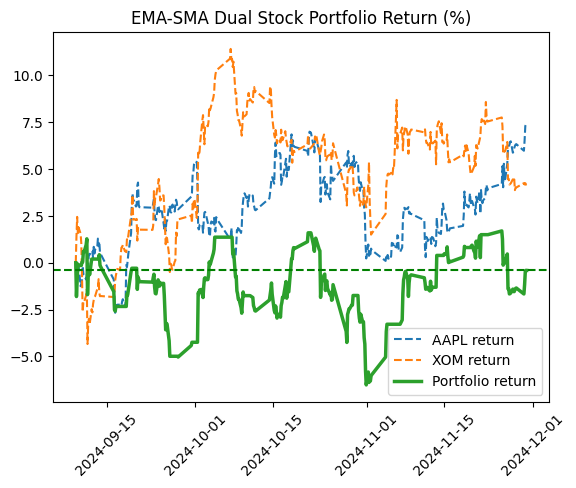

In [105]:
# for ticker in tickers:
#     plt.plot(result_df['date'], result_df[f'{ticker}:norm'], label=f'{ticker} return')

# plt.plot(result_df['date'], result_df['Portfolio:norm'], label='Portfolio return')
# plt.legend()
# plt.title('EMA-SMA 6 stock portfolio return')
# plt.show()

# Apply rolling mean for smoothing
window_size = 1  # Adjust the window size as needed
for ticker in tickers:
    result_df[f'{ticker}:smoothed'] = result_df[f'{ticker}:norm'].rolling(window=window_size).mean()

result_df['Portfolio:smoothed'] = result_df['Portfolio:norm'].rolling(window=window_size).mean()

# Plot the smoothed data
for ticker in tickers:
    plt.plot(result_df['date'], result_df[f'{ticker}:smoothed'], label=f'{ticker} return', linestyle='--')

plt.plot(result_df['date'], result_df['Portfolio:smoothed'], label='Portfolio return', linewidth=2.5)
plt.axhline(y=list(result_df['Portfolio:norm'])[-1], linestyle='--', color='green')
plt.legend()
plt.title('EMA-SMA Dual Stock Portfolio Return (%)')
plt.xticks(rotation=45)
plt.show()
